In [155]:
import numpy as np
import random
import geopandas as gpd
import contextily as ctx
import osmnx as ox
import networkx as nx
import h3
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Polygon, Point
from shapely.strtree import STRtree
from math import pi, cos, sin, exp, sqrt
from geopy.distance import geodesic
from pyproj import Transformer
from itertools import combinations


# SETUP

In [156]:
possibility_rail_df = pd.read_csv('nyc_possibility_graph_adj_matrix_rail.csv', index_col='Unnamed: 0')
possibility_road_df = pd.read_csv('nyc_possibility_graph_adj_matrix_highways.csv', index_col='Unnamed: 0')
possibility_rail_df

,872a10000ffffff,872a10001ffffff,872a10002ffffff,872a10003ffffff,872a10004ffffff,872a10005ffffff,872a10006ffffff,872a10008ffffff,872a10009ffffff,872a1000affffff,...,872a1076cffffff,872a1076dffffff,872a1076effffff,872a10770ffffff,872a10771ffffff,872a10772ffffff,872a10773ffffff,872a10774ffffff,872a10775ffffff,872a10776ffffff
872a10000ffffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
872a10001ffffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
872a10002ffffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
872a10003ffffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
872a10004ffffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872a10772ffffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
872a10773ffffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
872a10774ffffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
872a10775ffffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [157]:
express_flow_df = pd.read_csv('express_od.csv', index_col='Unnamed: 0')
scheduled_flow_df = pd.read_csv('scheduled_od.csv', index_col='Unnamed: 0')
scheduled_flow_df

,origin,destination,flow,origin_centroid,destination_centroid
0,872a100f4ffffff,872a1005affffff,5226.763876,POINT (-73.88486486777501 40.80020811701585),POINT (-73.76119091547939 40.69235907503999)
1,872a100f4ffffff,872a10054ffffff,4869.375546,POINT (-73.88486486777501 40.80020811701585),POINT (-73.73379556611397 40.767035428492335)
2,872a100f4ffffff,872a100f4ffffff,3959.142940,POINT (-73.88486486777501 40.80020811701585),POINT (-73.88486486777501 40.80020811701585)
3,872a100f4ffffff,872a1070bffffff,1329.113147,POINT (-73.88486486777501 40.80020811701585),POINT (-74.08847081276465 40.646693296459965)
4,872a100f4ffffff,872a10000ffffff,786.591551,POINT (-73.88486486777501 40.80020811701585),POINT (-73.7819280610591 40.85841765631943)
...,...,...,...,...,...
12590,872a100d5ffffff,872a106e5ffffff,179.508947,POINT (-73.92770161232309 40.74354854892256),POINT (-74.20147064969527 40.49572542028847)
12591,872a100d5ffffff,872a10602ffffff,15.241769,POINT (-73.92770161232309 40.74354854892256),POINT (-74.22041943437736 40.5874861982439)
12592,872a100d5ffffff,872a10383ffffff,4000.689362,POINT (-73.92770161232309 40.74354854892256),POINT (-73.7872110363715 40.58084058626897)
12593,872a100d5ffffff,872a10609ffffff,614.677897,POINT (-73.92770161232309 40.74354854892256),POINT (-74.15760160512743 40.51544480831601)


In [158]:
### Create HEX GDF
hex_ids = set(possibility_rail_df.index)

# Generate hex polygons in EPSG:4326 (lat, lon)
hex_polygons = []
for h in hex_ids:
    boundary = h3.cell_to_boundary(h)  # list of (lat, lon)
    # Swap to (lon, lat) for shapely
    polygon = Polygon([(lng, lat) for lat, lng in boundary])
    hex_polygons.append({'h3_index': h, 'geometry': polygon})

hex_gdf = gpd.GeoDataFrame(hex_polygons, crs="EPSG:4326")

In [159]:
def create_graph(adj_matrix, hex_gdf):
    centroid_dict = {}
    for idx, row in hex_gdf.iterrows():
        centroid_dict[row['h3_index']] = (row['geometry'].centroid.x, row['geometry'].centroid.y)

    G = nx.Graph()
    for node in centroid_dict.keys():
        G.add_node(node)

    for source in adj_matrix.index:
        for target in adj_matrix.columns:
            if adj_matrix.loc[source, target] == 1:
                G.add_edge(source, target)

    return G

In [160]:
centroid_dict = {}
for idx, row in hex_gdf.iterrows():
    centroid_dict[row['h3_index']] = (row['geometry'].centroid.x, row['geometry'].centroid.y)

In [161]:
G_rail = create_graph(possibility_rail_df, hex_gdf)
G_road = create_graph(possibility_road_df, hex_gdf)

In [162]:
G_combined = nx.Graph()
for node in centroid_dict.keys():
    G_combined.add_node(node)

for u, v in G_road.edges():
    G_combined.add_edge(u, v, source='road')
for u, v in G_rail.edges():
    if G_combined.has_edge(u, v):
        G_combined[u][v]['source'] = 'both'
    else:
        G_combined.add_edge(u, v, source='rail')

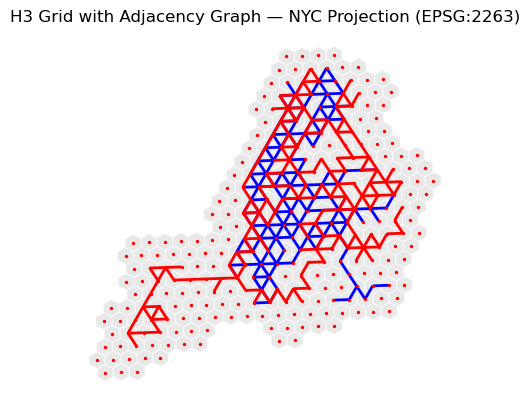

In [163]:
hex_gdf_2263 = hex_gdf.to_crs(epsg=2263)

transformer = Transformer.from_crs("EPSG:4326", "EPSG:2263", always_xy=True)
pos_proj = {
    node: transformer.transform(*centroid_dict[node])  # note: centroid_dict already lon, lat order
    for node in G_combined.nodes
}

# --- Plot ---
fig, ax = plt.subplots(figsize=(5, 5))
hex_gdf_2263.plot(ax=ax, facecolor='lightgrey', edgecolor='white', alpha=0.5)
nx.draw_networkx_edges(G_rail, pos=pos_proj, ax=ax, edge_color='blue', width=2, alpha=1)
nx.draw_networkx_edges(G_road, pos=pos_proj, ax=ax, edge_color='red', width=2, alpha=1)
nx.draw_networkx_nodes(G_combined, pos=pos_proj, ax=ax, node_size=2, node_color='red')

ax.set_title("H3 Grid with Adjacency Graph — NYC Projection (EPSG:2263)")
ax.axis('off')
plt.show()


# Optimisation

In [164]:
combined_flow_df = pd.concat([express_flow_df, scheduled_flow_df], ignore_index=True).groupby(['origin', 'destination'], as_index=False)['flow'].agg({
    'flow': 'sum',     # sum this column
    'origin_centroid': 'first',      # keep the original value (assumed same in group)
    'destination_centroid': 'first'       # keep the original value (assumed same in group)
})
combined_flow_df

/var/folders/n6/07flntc946j046ynznszq86w0000gn/T/ipykernel_3814/2179087640.py:1: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  combined_flow_df = pd.concat([express_flow_df, scheduled_flow_df], ignore_index=True).groupby(['origin', 'destination'], as_index=False)['flow'].agg({


,origin,destination,flow,origin_centroid,destination_centroid
0,872a10000ffffff,872a10000ffffff,537.943500,537.943500,537.943500
1,872a10000ffffff,872a10001ffffff,435.408076,435.408076,435.408076
2,872a10000ffffff,872a10002ffffff,2771.790590,2771.790590,2771.790590
3,872a10000ffffff,872a10003ffffff,1416.221608,1416.221608,1416.221608
4,872a10000ffffff,872a10006ffffff,93.976707,93.976707,93.976707
...,...,...,...,...,...
40757,872a10776ffffff,872a10772ffffff,91799.090756,5102.686990,5102.686990
40758,872a10776ffffff,872a10773ffffff,365034.770357,20971.574951,20971.574951
40759,872a10776ffffff,872a10774ffffff,314106.962037,15758.978343,15758.978343
40760,872a10776ffffff,872a10775ffffff,331514.538077,18407.739779,18407.739779


In [165]:
combined_flow_df['origin'] = combined_flow_df['origin'].astype(str)
combined_flow_df['destination'] = combined_flow_df['destination'].astype(str)

# Step 1: Create normalized edge keys (undirected)
combined_flow_df['edge_key'] = combined_flow_df.apply(
    lambda row: tuple(sorted([row['origin'], row['destination']])), axis=1
)

# Step 2: Sum flows in both directions
symmetric_flow = combined_flow_df.groupby('edge_key')['flow'].sum().reset_index()

# Step 3: Split back into origin and destination
symmetric_flow[['origin', 'destination']] = pd.DataFrame(
    symmetric_flow['edge_key'].tolist(), index=symmetric_flow.index
)

# Step 4: Create initial pivot table
adj_matrix = symmetric_flow.pivot(index='origin', columns='destination', values='flow')

# Step 5: Build full node list from G_combined AND combined_flow_df
nodes_from_graph = set(map(str, G_combined.nodes))
nodes_from_df = set(combined_flow_df['origin']).union(set(combined_flow_df['destination']))
all_nodes = sorted(nodes_from_graph.union(nodes_from_df))

# Step 6: Reindex both rows and columns to include all nodes
adj_matrix = adj_matrix.reindex(index=all_nodes, columns=all_nodes, fill_value=0)

# Step 7: Force symmetry
adj_matrix = adj_matrix.combine_first(adj_matrix.T)

# Step 8: Final cleanup: fill NaNs and ensure float type
adj_matrix = adj_matrix.fillna(0).astype(float)

adj_matrix

,872a10000ffffff,872a10001ffffff,872a10002ffffff,872a10003ffffff,872a10004ffffff,872a10005ffffff,872a10006ffffff,872a10008ffffff,872a10009ffffff,872a1000affffff,...,872a1076cffffff,872a1076dffffff,872a1076effffff,872a10770ffffff,872a10771ffffff,872a10772ffffff,872a10773ffffff,872a10774ffffff,872a10775ffffff,872a10776ffffff
origin,,,,,,,,,,,,,,,,,,,,,
872a10000ffffff,537.943500,435.408076,2828.881940,1770.687540,0.0,0.0,93.976707,155.368336,362.349706,1545.986104,...,721.106504,6.471335,144.241561,1500.923339,1058.626959,685.544606,1004.300992,1996.221405,993.255299,1102.047238
872a10001ffffff,435.408076,0.000000,49.028148,366.333276,0.0,0.0,0.000000,0.000000,0.000000,85.855221,...,798.415619,0.000000,22.877056,1004.211760,298.339817,566.326659,458.228106,1451.586468,209.421558,1065.014147
872a10002ffffff,2828.881940,49.028148,503.399466,2590.082031,0.0,0.0,13.025725,19.465157,44.865470,676.769819,...,5704.816102,0.961952,160.901144,8200.958433,2404.900953,4856.466522,3552.388792,11598.193726,1571.430297,9161.982574
872a10003ffffff,1770.687540,366.333276,2590.082031,1561.258033,0.0,0.0,66.269010,156.030528,359.636607,1907.738860,...,3112.557601,7.138255,223.394066,4778.651850,2080.930945,2553.784015,2498.059449,6684.210120,1715.638897,4605.580480
872a10004ffffff,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872a10772ffffff,685.544606,566.326659,4856.466522,2553.784015,0.0,0.0,125.701312,363.488610,991.418924,4669.073577,...,25779.131898,494.811209,19180.545399,315383.989427,291031.817827,77065.254598,357693.393511,274778.006411,222728.313221,111441.114804
872a10773ffffff,1004.300992,458.228106,3552.388792,2498.059449,0.0,0.0,89.012328,328.029355,981.255337,4209.466018,...,147294.889182,1060.697889,41127.889948,719932.920569,536177.690909,357693.393511,433960.277967,625494.368825,343293.389221,382319.423176
872a10774ffffff,1996.221405,1451.586468,11598.193726,6684.210120,0.0,0.0,297.048465,990.483590,2835.979890,12480.463704,...,106434.752152,1523.827619,51492.178257,765711.764385,638656.552607,274778.006411,625494.368825,509708.799565,605594.958154,350828.556736


In [166]:
def euclidean_distance(coord1, coord2):
    # assumes (lon, lat) tuple, in degrees — treat as planar here
    return sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2) * 111  # ~km scale

def precompute_distances(centroid_dict):
    dist_dict = {}
    for u, coord_u in centroid_dict.items():
        dist_dict[u] = {}
        for v, coord_v in centroid_dict.items():
            dist = euclidean_distance(coord_u, coord_v)
            dist_dict[u][v] = dist
    return dist_dict

def compute_total_benefit_np(G, benefit_array, node_index, centroid_dict, dist_dict, alpha=1.5, distance_cap=50.0):
    total_benefit = 0
    all_nodes = list(node_index.keys())

    # Map each node to its connected component ID
    node_to_component = {}
    for i, component in enumerate(nx.connected_components(G)):
        for node in component:
            node_to_component[node] = i

    for i, u in enumerate(all_nodes):
        for j in range(i+1, len(all_nodes)):  # only upper triangle to avoid double counting
            v = all_nodes[j]
            benefit = benefit_array[i, j]
            if benefit == 0:
                continue

            if node_to_component.get(u) == node_to_component.get(v):
                # Fully connected → full benefit
                total_benefit += benefit
            else:
                # Disconnected → apply discounted benefit
                dist = dist_dict[u][v]
                if dist <= distance_cap:
                    total_benefit += benefit * np.exp(-alpha * dist)

    return total_benefit


In [167]:
TARGET_EDGE_NUM = 80
MUTATION_RATE = 0.3 

# def compute_total_benefit(G, benefits):
#     total = 0
#     for component in nx.connected_components(G):
#         nodes = list(component)
#         for i in range(len(nodes)):
#             for j in range(i+1, len(nodes)):
#                 u, v = nodes[i], nodes[j]
#                 total += benefits.loc[u, v]
#     return total

def create_graph_from_edges(edge_list, nodes):
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edge_list)
    return G

def generate_initial_population_connected_partial(G_full, population_size, k, min_connected_nodes=5):
    edges = list(G_full.edges())
    nodes = list(G_full.nodes())

    population = []

    for _ in range(population_size):
        # Step 1: pick random subset of nodes to be connected
        m = min(len(nodes), k + 1)  # max nodes that can be connected with k edges
        connected_nodes = random.sample(nodes, random.randint(min_connected_nodes, m))

        # Step 2: build a random spanning tree on those
        subgraph = G_full.subgraph(connected_nodes).copy()
        for (u, v) in subgraph.edges():
            subgraph[u][v]['weight'] = random.random()
        tree = nx.minimum_spanning_tree(subgraph, weight='weight')
        tree_edges = list(tree.edges())

        # Step 3: add random extra edges
        candidate_edges = list(set(edges) - set(tree_edges))
        extra_count = k - len(tree_edges)
        extra_edges = random.sample(candidate_edges, min(extra_count, len(candidate_edges))) if extra_count > 0 else []

        chromosome = tree_edges + extra_edges
        population.append(chromosome)

    return population



# def crossover(parent1, parent2, k):
#     combined = list(set(parent1) | set(parent2))
#     if len(combined) > k:
#         return random.sample(combined, k)
#     else:
#         # pad with random edges to ensure size k
#         return combined + random.sample(list(set(edges) - set(combined)), k - len(combined))

def crossover(parent1, parent2, k):
    child = []
    candidates = list(set(parent1 + parent2))
    while len(child) < k:
        e = random.choice(candidates)
        if e not in child:
            child.append(e)
    return child

# def structured_crossover(parent1, parent2, k, node_list):
#     # Create subgraphs
#     half_k = k // 2
#     child_edges = list(set(parent1[:half_k] + parent2[:half_k]))
#     missing = k - len(child_edges)

#     if missing > 0:
#         filler_pool = list(set(parent1 + parent2) - set(child_edges))
#         random.shuffle(filler_pool)
#         child_edges += filler_pool[:missing]

#     return child_edges[:k]

# def crossover(parent1, parent2, k, all_edges, node_list):
#     # Step 1: Start with shared edges
#     shared_edges = list(set(parent1) & set(parent2))
#     extra_pool = list(set(parent1 + parent2) - set(shared_edges))

#     child_edges = shared_edges.copy()

#     # Step 2: Add random edges from parent pool until reaching k
#     while len(child_edges) < k and extra_pool:
#         new_edge = random.choice(extra_pool)
#         extra_pool.remove(new_edge)
#         if new_edge not in child_edges:
#             child_edges.append(new_edge)

#     # Step 3: If still not k edges, pad from full edge set
#     padding_pool = list(set(all_edges) - set(child_edges))
#     while len(child_edges) < k and padding_pool:
#         new_edge = random.choice(padding_pool)
#         padding_pool.remove(new_edge)
#         child_edges.append(new_edge)

#     # Step 4: Attempt to connect the graph if it's disconnected
#     G_temp = create_graph_from_edges(child_edges, node_list)
#     components = list(nx.connected_components(G_temp))
#     if len(components) > 1:
#         # Create a list of component representatives
#         rep_nodes = [list(c)[0] for c in components]

#         # Try to connect components using edges from all_edges
#         connecting_edges = []
#         for i in range(len(rep_nodes)):
#             for j in range(i + 1, len(rep_nodes)):
#                 u = rep_nodes[i]
#                 v = rep_nodes[j]
#                 if (u, v) in all_edges or (v, u) in all_edges:
#                     connecting_edges.append((u, v) if (u, v) in all_edges else (v, u))

#         random.shuffle(connecting_edges)
#         for e in connecting_edges:
#             if e not in child_edges:
#                 child_edges.append(e)
#                 G_temp.add_edge(*e)
#                 if nx.is_connected(G_temp):
#                     break

#         # Trim excess edges if we overshot
#         if len(child_edges) > k:
#             child_edges = child_edges[:k]

#     return child_edges

def mutate(chromosome, edges, mutation_rate=MUTATION_RATE):
    chromosome = chromosome.copy()
    for i in range(len(chromosome)):
        if random.random() < mutation_rate:
            new_edge = random.choice(list(set(edges) - set(chromosome)))
            chromosome[i] = new_edge
    return chromosome

def smart_mutate(chromosome, edges, G_full, mutation_rate=MUTATION_RATE):
    chromosome = chromosome.copy()
    edge_set = set(edges)
    chromo_set = set(chromosome)

    for i in range(len(chromosome)):
        if random.random() < mutation_rate:
            # Remove an edge
            removed_edge = chromosome[i]
            # Try adding a new edge that connects new nodes
            new_edge = random.choice(list(edge_set - chromo_set))
            chromosome[i] = new_edge
            chromo_set.remove(removed_edge)
            chromo_set.add(new_edge)
    return chromosome

def select_parents(population, fitnesses):
    total_fitness = sum(fitnesses)
    probs = [f / total_fitness for f in fitnesses]
    parents = random.choices(population, weights=probs, k=2)
    return parents

def tournament_selection(population, fitnesses, tournament_size=5):
    selected = random.sample(list(zip(population, fitnesses)), tournament_size)
    return max(selected, key=lambda x: x[1])[0]

def genetic_algorithm(edges, benefits, node_list, generations, population_size, k, dist_dict):
    # population = generate_initial_population(edges, population_size, k)
    G_full = nx.Graph()
    G_full.add_edges_from(edges)

    population = generate_initial_population_connected_partial(
        G_full, population_size, k, min_connected_nodes=5
    )

    best_fitness_history = []
    
#     # Convert benefits to numpy sssuming `benefits` is a DataFrame with symmetric values and node labels as both index and columns
#     benefit_array = benefits.to_numpy()
#     node_list = benefits.index.to_list()
    node_index = {node: i for i, node in enumerate(node_list)}  # map from node to row/col index
    benefit_array = benefits


    for generation in range(generations):
        fitnesses = []
        for chromo in population:
            G = create_graph_from_edges(chromo, node_list)
            # fitnesses.append(compute_total_benefit(G, benefits))
            fitnesses.append(compute_total_benefit_np(G, benefits, node_index, centroid_dict, dist_dict))
            

        ### Option 1
        elite_count = 5  # or any small number like 2–10
            # Zip population with their fitnesses and sort in descending order
        sorted_pop = sorted(zip(population, fitnesses), key=lambda x: x[1], reverse=True)
            # Keep top N elites
        new_population = [ind for ind, _ in sorted_pop[:elite_count]]
        best_fitness = sorted_pop[0][1]
        ###
        ### Option 2
        # best_idx = np.argmax(fitnesses)
        # best_fitness = fitnesses[best_idx]
        # new_population = [population[best_idx]]  # elitism
        ###
        best_fitness_history.append(best_fitness)
        print(f"Generation {generation}: Best Benefit = {best_fitness}")

        

        while len(new_population) < population_size:
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            child = crossover(parent1, parent2, k)
            # child = crossover(parent1, parent2, k, all_edges=edges, node_list=node_list)
            # child = structured_crossover(parent1, parent2, k, node_list)
            # child = mutate(child, edges, mutation_rate=MUTATION_RATE)
            child = smart_mutate(child, edges, G_full, mutation_rate=MUTATION_RATE)
            new_population.append(child)

        population = new_population

    # Final best
    # final_fitnesses = [compute_total_benefit(create_graph_from_edges(chromo, nodes), benefits)
    #                    for chromo in population]
    final_fitnesses = [compute_total_benefit_np(create_graph_from_edges(chromo, node_list), benefits, node_index, centroid_dict, dist_dict)
                       for chromo in population]
    
    best_idx = np.argmax(final_fitnesses)
    best_edges = population[best_idx]

    return best_edges, best_fitness_history


Generation 0: Best Benefit = 263255698.58248323
Generation 1: Best Benefit = 263255698.58248323
Generation 2: Best Benefit = 263255698.58248323
Generation 3: Best Benefit = 263255698.58248323
Generation 4: Best Benefit = 263255698.58248323
Generation 5: Best Benefit = 263255698.58248323
Generation 6: Best Benefit = 263255698.58248323
Generation 7: Best Benefit = 263255698.58248323
Generation 8: Best Benefit = 263255698.58248323
Generation 9: Best Benefit = 263255698.58248323
Generation 10: Best Benefit = 263255698.58248323
Generation 11: Best Benefit = 263255698.58248323
Generation 12: Best Benefit = 263255698.58248323
Generation 13: Best Benefit = 293342286.974144
Generation 14: Best Benefit = 293342286.974144
Generation 15: Best Benefit = 293342286.974144
Generation 16: Best Benefit = 293342286.974144
Generation 17: Best Benefit = 293342286.974144
Generation 18: Best Benefit = 293342286.974144
Generation 19: Best Benefit = 293342286.974144
Generation 20: Best Benefit = 293342286.9741

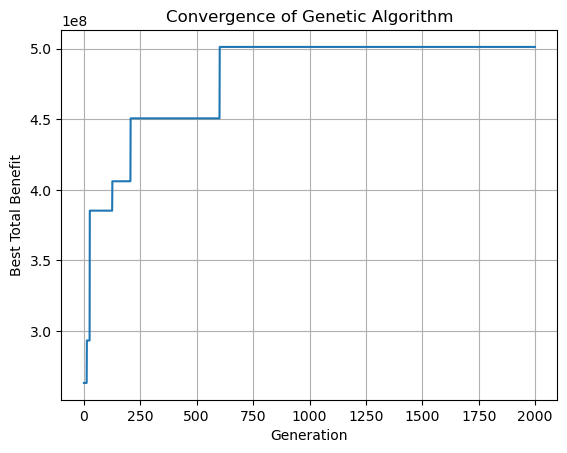

In [168]:
assert adj_matrix.index.equals(adj_matrix.columns), "adj_matrix is not symmetric in labels!"

dist_dict = precompute_distances(centroid_dict)
benefit_array = adj_matrix.values

best_edges, history = genetic_algorithm(list(G_combined.edges()),
                                        benefit_array,
                                        list(adj_matrix.index),
                                        generations=2000,
                                        population_size=100,
                                        k=TARGET_EDGE_NUM,
                                        dist_dict=dist_dict)

plt.plot(history)
plt.title("Convergence of Genetic Algorithm")
plt.xlabel("Generation")
plt.ylabel("Best Total Benefit")
plt.grid(True)
plt.show()

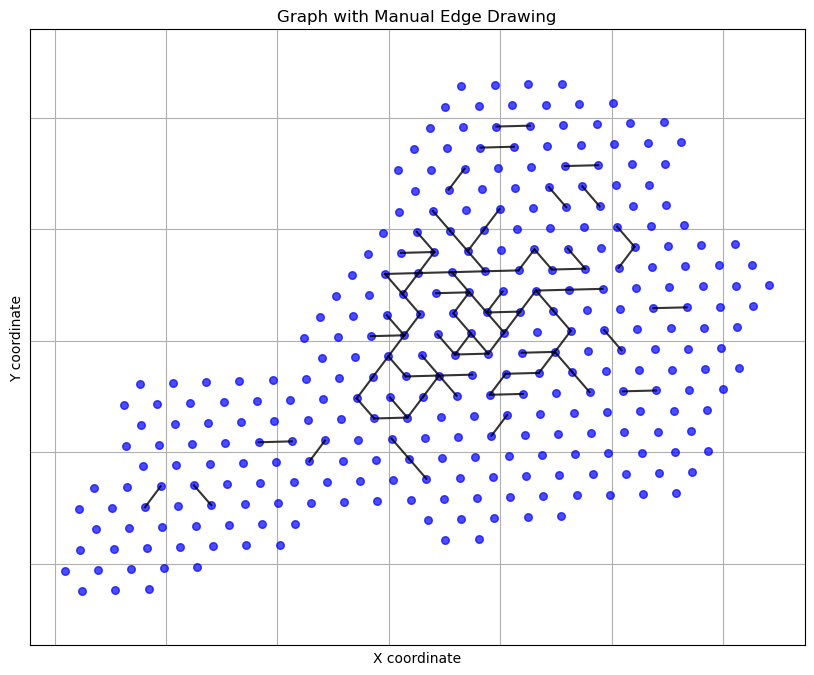

In [139]:
pos = {}
for node in centroid_dict:
    pt = centroid_dict[node]
    pos[node] = (pt[0], pt[1])

def plot_graph_with_manual_edges(G, pos, node_color='blue', edge_color='black'):
    plt.figure(figsize=(10, 8))
    # Draw nodes
    
    nx.draw_networkx_nodes(G, pos, node_size=30, node_color=node_color, alpha=0.7)

    # Draw edges manually
    for u, v in G.edges():
        x_vals = [pos[u][0], pos[v][0]]
        y_vals = [pos[u][1], pos[v][1]]
        plt.plot(x_vals, y_vals, color=edge_color, alpha=0.8, linewidth=1.5)

    plt.title("Graph with Manual Edge Drawing")
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.show()

# Call it
G_final = create_graph_from_edges(best_edges, G_combined.nodes())
plot_graph_with_manual_edges(G_final, pos)


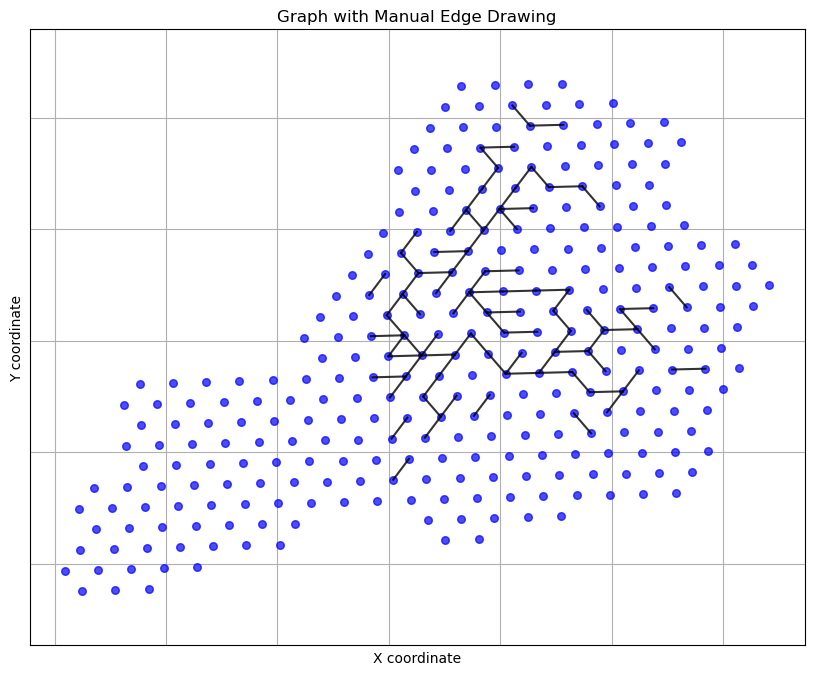

In [ ]:
pos = {}
for node in centroid_dict:
    pt = centroid_dict[node]
    pos[node] = (pt[0], pt[1])

def plot_graph_with_manual_edges(G, pos, node_color='blue', edge_color='black'):
    plt.figure(figsize=(10, 8))
    # Draw nodes
    
    nx.draw_networkx_nodes(G, pos, node_size=30, node_color=node_color, alpha=0.7)

    # Draw edges manually
    for u, v in G.edges():
        x_vals = [pos[u][0], pos[v][0]]
        y_vals = [pos[u][1], pos[v][1]]
        plt.plot(x_vals, y_vals, color=edge_color, alpha=0.8, linewidth=1.5)

    plt.title("Graph with Manual Edge Drawing")
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.show()

# Call it
G_final = create_graph_from_edges(best_edges, G_combined.nodes())
plot_graph_with_manual_edges(G_final, pos)
